In [0]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sps

# Dataset, binary data and continuous data

In [0]:
def digit_basis(geometry):
    num_bit = np.prod(geometry)
    M = 2**num_bit
    x = np.arange(M)
    return x

def binary_basis(geometry):
    num_bit = np.prod(geometry)
    M = 2**num_bit
    x = np.arange(M)
    return unpacknbits(x[:,None], num_bit).reshape((-1,)+geometry)

def unpacknbits(arr, nbit, axis=-1):
    '''unpack numbers to bitstrings.'''
    nd = np.ndim(arr)
    if axis < 0:
        axis = nd + axis
    return (((arr & (1 << np.arange(nbit - 1, -1, -1)).reshape([-1] + [1] * (nd - axis - 1)))) > 0).astype('int8')


def packnbits(arr, axis=-1):
    '''pack bitstrings to numbers.'''
    nd = np.ndim(arr)
    nbit = np.shape(arr)[axis]
    if axis < 0:
        axis = nd + axis
    return (arr * (1 << np.arange(nbit - 1, -1, -1)).reshape([-1] + [1] * (nd - axis - 1))\
           ).sum(axis=axis, keepdims=True).astype('int')

In [0]:
def gaussian_pdf(geometry, mu, sigma):
    '''get gaussian distribution function'''
    x = digit_basis(geometry)
    pl = 1. / np.sqrt(2 * np.pi * sigma**2) * \
        np.exp(-(x - mu)**2 / (2. * sigma**2))
    return pl/pl.sum()

In [0]:
def barstripe_pdf(geometry):
    '''get bar and stripes PDF'''
    x = binary_basis(geometry)
    pl = is_bs(x)
    return pl/pl.sum()

def is_bs(samples):
    '''a sample is a bar or a stripe.'''
    return (np.abs(np.diff(samples,axis=-1)).sum(axis=(1,2))==0\
           )|((np.abs(np.diff(samples, axis=1)).sum(axis=(1,2)))==0)

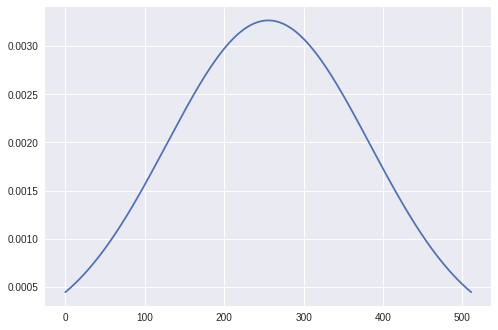

In [5]:
num_bit = 9
pl1 = gaussian_pdf((num_bit,), mu=2**(num_bit-1)-0.5, sigma=2**(num_bit-2))
plt.plot(pl1)
plt.show()

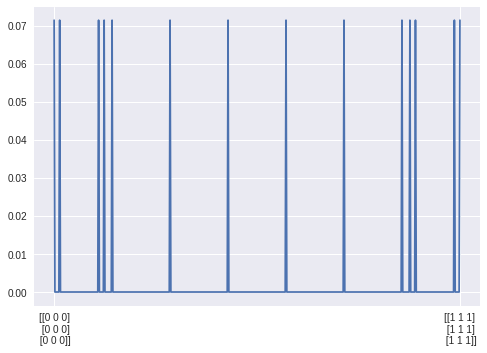

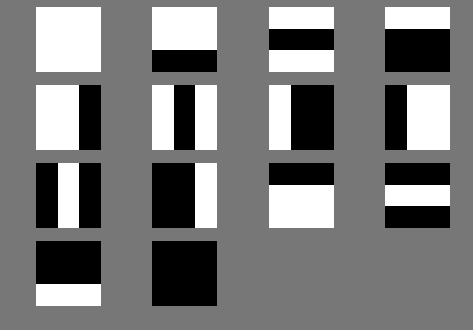

In [6]:
geometry = (3,3)
pl2 = barstripe_pdf(geometry)
plt.plot(pl2)

# show ticks
basis = binary_basis(geometry)
plt.xticks([0, 511], [basis[0], basis[511]])
plt.show()

# generate samples
samples = basis[pl2>1e-2]

# show bar and stripes
def plot_bs(samples, size):
    plt.figure(facecolor='#777777')
    gs = plt.GridSpec(*size)

    for i in range(size[0]):
        for j in range(size[1]):
            if i*size[1]+j == len(samples): break
            plt.subplot(gs[i,j]).imshow(samples[i*size[1]+j], vmin=0, vmax=1)
            plt.axis('equal')
            plt.axis('off')
    plt.show()

size = (4, 4)
plot_bs(samples, size)

# Kernel Two Sample Test
## Kernel Method
Given a vector $x$ in $n$-dimensional space, we perform the mapping to reproducing kernel Hilbert space (RKHS) $x\rightarrow \phi(x)$.
Define the inner product as $\phi(x)^T\phi = K(x,x')$, this is the kernel function.
Good let's see a simple example of polynomial kernel function $K(x,y)=(x^T y)^2=\sum_{ij} x_i y_i x_j y_j$
The mapping should be $\phi(x)=x\otimes x$.

#### Ref
Hofmann, T., Scholkopf, B., & Smola, A. J. (2008). Kernel methods in machine learning. Annals of Statistics, 36(3), 1171–1220. https://doi.org/10.1214/009053607000000677

In [7]:
# define the kernel and mapping
K = lambda x, y: x.dot(y)**2
phi = lambda x: (x[:,None]*x).ravel()

# randomly generate some vectors
num_sample = 10
num_dim = 100
x = np.random.randn(num_sample, num_dim)

print("Size of x = %d"%x[0].size)
print("Size of phi(x) = %d"%phi(x[0]).size)

kmat = np.zeros([num_sample, num_sample])

for i in range(num_sample):
    for j in range(num_sample):
        kmat[i, j] = K(x[i], x[j])
        np.testing.assert_almost_equal(kmat[i, j], phi(x[i]).dot(phi(x[j])))

Size of x = 100
Size of phi(x) = 10000


## Properties
* K is ususally chosen as **positive definite**, the Moore–Aronszajn theorem states that, for every positive definite kernel, there exists a unique RKHS and vice versa.
* sometimes RKHS can be $\infty$-dimensional, e.g. RBF kernel $K(x,y) = \exp(\frac{\|x-y\|}{2\sigma})$

In [8]:
# get all eigen values
print(np.linalg.eigvalsh(kmat), "are all positive!")

[ 6705.47440995  8237.20293944  9835.08782136 10220.3915002
 11378.71166636 11835.40403696 13443.38452008 13744.29091067
 15806.48534292 16826.94894898] are all positive!


## Kernel Two Sample Test (MMD)
Defined as the distance in RKHS between two mean embeddings
\begin{align}
    \mathcal{L} =&  \left\|\sum_{x} p_\theta(x) \phi(x)- \sum_{x} \pi(x) \phi(x)  \right\|^2 \\
    =&\langle K(x,y)\rangle_{x\sim p_\theta, y\sim p_\theta}-2\langle K(x,y)\rangle_{x\sim p_\theta,y\sim \pi}+\langle K(x, y)\rangle_{x\sim \pi,y\sim \pi}
\end{align}

#### Ref
Gretton, A. (2012). A Kernel Two-Sample Test. Journal of Machine Learning Research, 13, 723–773. Retrieved from http://kyb.tuebingen.mpg.de/publications/attachments/NIPS2009-Gretton_[0].pdf

## Probability embedding

We next extend the notion of feature map to the embedding of a probability distribution: we will define an element $\mu(p)\in \mathcal H$ such that $E_x(f) = f^T \mu_p$ for all $f \in \mathcal H$.

**Theorem 5**
Let $\mathcal F$ be a unit ball in a **universal** RKHS $\mathcal{H}$, defined on the compact metric space $\mathcal X$, with associated continuous kernel $k(·, ·)$. Then MMD$[\mathcal F, p,q]=0$ if and only if $p=q$.

* universal RKHS: By the universality of $\mathcal H$, for any given $\epsilon > 0$ and $f \in C(X)$ (bounded continuous function) there exists a $g \in \mathcal H$ such that $\|f-g\|_\infty\leq \epsilon$. e.g. Gaussian and Laplace kernels (I. Steinwart. On the influence of the kernel on the consistency of support vector machines. Journal of Machine Learning Research, 2:67–93, 2001.).

#### Ref
A.Berlinet and C. Thomas-Agnan. Reproducing KernelHilbert Spaces in Probability and Statistics. Kluwer, 2004. Chapter 4.

In [0]:
class RBFMMD2(object):
    def __init__(self, sigma_list, basis):
        self.sigma_list = sigma_list
        self.basis = basis
        self.K = mix_rbf_kernel(self.basis, self.basis, self.sigma_list)

    def __call__(self, px, py):
        '''
        Args:
            px (1darray, default=None): probability for data set x, used only when self.is_exact==True.
            py (1darray, default=None): same as px, but for data set y.

        Returns:
            float, loss.
        '''
        pxy = px-py
        return self.kernel_expect(pxy, pxy)

    def kernel_expect(self, px, py):
        return px.dot(self.K.dot(py))

    def witness(self, px, py):
        '''witness function of this kernel.'''
        return self.K.dot(px-py)


def mix_rbf_kernel(x, y, sigma_list):
    ndim = x.ndim
    if ndim == 1:
        exponent = np.abs(x[:, None] - y[None, :])**2
    elif ndim == 2:
        exponent = ((x[:, None, :] - y[None, :, :])**2).sum(axis=2)
    else:
        raise
    K = 0.0
    for sigma in sigma_list:
        gamma = 1.0 / (2 * sigma)
        K = K + np.exp(-gamma * exponent)
    return K

### Witness Function
To see how sensitive the MMD loss to the probability difference defined as $\delta (x) = p(x)-\pi(x)$. We define
$$W_\pi(x)\propto \langle \phi(x), \mu_p-\mu_\pi \rangle_{\rm RKHS}=E_y[K(y\sim p,x)]-E_y[K(y\sim\pi, x)]$$
So that $\mathcal{L}=\delta (x)^TW_\pi(x)$.

Give a target empirical distribution $\hat{\pi}(x) = \sum\limits_{d_i \in \mathcal{D}} \delta(x-d_i)$, see witness function.

If p = q, then mmd = 0.0000
If p != q, then mmd = 0.0822


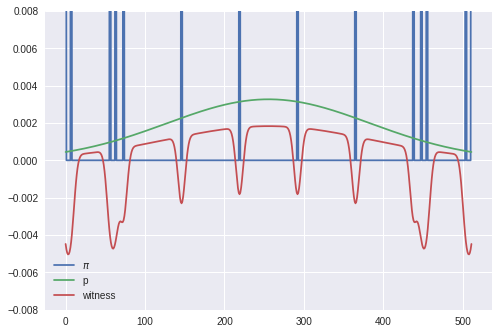

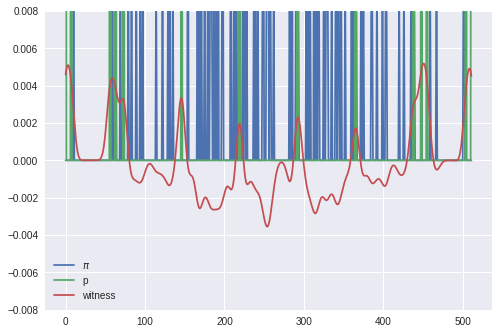

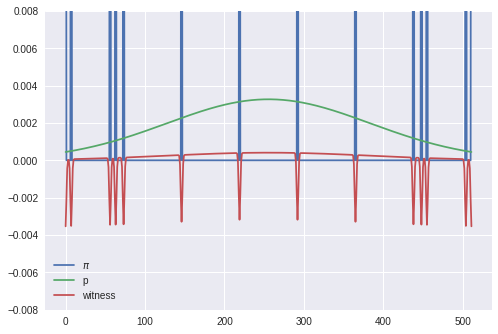

In [15]:
basis = digit_basis(num_bit)
mmd = RBFMMD2([20], basis)
print("If p = q, then mmd = %.4f"%mmd(pl1, pl1))
print("If p != q, then mmd = %.4f"%mmd(pl1, pl2))

def show_witness(p, pi):
    wit = mmd.witness(p, pi)
    plt.plot(basis, np.transpose([pi, p, wit/20]))
    plt.legend(['$\pi$', 'p', 'witness'])
    plt.ylim(-0.008,0.008)
    plt.show()
    
def _empirical(pi, num_sample):
    '''turn a distribution function to empirical distribution function.'''
    samples = np.random.choice(np.arange(2**num_bit), (num_sample,), p=pl1)
    px = np.bincount(samples, minlength=2**num_bit)
    px = px / float(np.sum(px))
    return px

# witness function using band-width 20
show_witness(pl1, pl2)

# witness function using empirical (spiky) distribution
pl1_ = _empirical(pl1, 100)
show_witness(pl2, pl1_)

# witness function using narrower bandwidth
mmd = RBFMMD2([1], basis)
show_witness(pl1, pl2)

# Building Differentiable Circuits

<div>
$$
\newcommand{\dataset}{{\mathcal{D}}}
\newcommand{\wfunc}{{\psi}}
\newcommand{\thetav}{{\boldsymbol{\theta}}}
\newcommand{\gammav}{{\boldsymbol{\gamma}}}
\newcommand{\thetai}{{\theta^\alpha_l}}
\newcommand{\Expect}{{\mathbb{E}}}
\newcommand{\etc}{{\it etc~}}
\newcommand{\etal}{{\it etal~}}
\newcommand{\xset}{\mathbf{X}}
\newcommand{\gammaset}{\boldsymbol{\Gamma}}
\newcommand{\ei}{\mathbf{e}_l^\alpha}
\newcommand{\sigmag}{{\nu}}
\newcommand{\BAS}{Bars-and-Stripes}
\newcommand{\qexpect}[1]{{\left\langle #1\right\rangle}}
\newcommand{\expect}[2]{{\mathop{\mathbb{E}}\limits_{\substack{#2}}\left[#1\right]}}
\newcommand{\pshift}[1]{{p_{\thetav+#1}}}
$$
</div>

### For an Obserable

Consider the expect of $B$ on state <span>$\vert\psi_N\rangle = U_{N:k+1} U_k(\eta)U_{k-1:1}\vert\psi_0\rangle$</span> with $U_k(\eta)=e^{i\Xi(\eta)}$,
The first task is to get the derivation of the graident of an expectation value that appear in Ref. [2-4] briefly, the gradient
<div>$$\begin{align}\frac{\partial \langle B\rangle_\eta}{\partial \eta} &=i\langle \psi_0\vert U_{N:1}^\dagger BU_{N:k+1} \frac{\partial \Xi(\eta)}{\partial \eta} U_{k:1}\vert \psi_0\rangle-i\langle \psi_0\vert U_{k:1}^\dagger \frac{\partial \Xi(\eta)}{\partial \eta} U_{N:k+1}^\dagger BU_{N:1}\vert \psi_0\rangle\end{align}$$</div>
Here, we have used the fact that $\Xi(\eta)$ is Hermitian. Define $O_{k+1}\equiv U_{N:k+1}^\dagger BU_{N:k+1}$ and $\vert \psi_{k}\rangle\equiv U_{k:1}\vert \psi_0\rangle$, we have
<div>$$\begin{equation}\frac{\partial \langle B\rangle_\eta}{\partial \eta} =\langle\psi_{k}\vert  i\left[O_{k+1}, \frac{\partial \Xi(\eta)}{\partial \eta}\right]\vert \psi_{k}\rangle.\end{equation}$$</div>
Define $A_\pm\equiv\frac{1}{\sqrt{2}} (1\pm i\frac{\partial \Xi(\eta)}{\partial \eta})$, we can easily verify that $ i\left[O_{k+1}, \frac{\partial \Xi(\eta)}{\partial \eta}\right]= A^\dagger_+ O_{k+1}A_+-A_-^\dagger O_{k+1}A_-$,
which can be estimated unbiasedly by constructing $\vert \psi_N\rangle_\pm = U_{N:k+1}A_\pm U_{k:1}\vert \psi_0\rangle$.
Noticing for a non-dissipative system, we further require $A$ being unitary, which means $\frac{\partial \Xi(\eta)}{\partial \eta}^2=1$ (e.g. Pauli operators, CNOT and SWAP).


In [0]:
######  Pauli Matrices  ########

I2 = sps.eye(2).tocsr()
sx = sps.csr_matrix([[0,1],[1,0.]])
sy = sps.csr_matrix([[0,-1j],[1j,0.]])
sz = sps.csr_matrix([[1,0],[0,-1.]])

p0 = (sz + I2) / 2
p1 = (-sz + I2) / 2
h = (sx + sz) / np.sqrt(2.)
sxyz = [I2, sx, sy, sz]

# single bit rotation matrices

def _ri(si, theta):
    return np.cos(theta/2.)*I2 - 1j*np.sin(theta/2.)*si

def rx(theta):
    return _ri(sx, theta)

def ry(theta):
    return _ri(sy, theta)

def rz(theta):
    return _ri(sz, theta)

def rot(t1, t2, t3):
    '''
    a general rotation gate rz(t3)rx(r2)rz(t1).

    Args:
        t1, t2, t3 (float): three angles.

    Returns:
        2x2 csr_matrix: rotation matrix.
    '''
    return rz(t3).dot(rx(t2)).dot(rz(t1))

# multiple bit construction

def CNOT(ibit, jbit, n):
    res = _([p0, I2], [ibit, jbit], n)
    res = res + _([p1, sx], [ibit, jbit], n)
    return res

def _(ops, locs, n):
    '''
    Put operators in a circuit and compile them.

    notice the big end are high loc bits!

    Args:
        ops (list): list of single bit operators.
        locs (list): list of positions.
        n (int): total number of bits.

    Returns:
        csr_matrix: resulting matrix.
    '''
    if np.ndim(locs) == 0:
        locs = [locs]
    if not isinstance(ops, (list, tuple)):
        ops = [ops]
    locs = np.asarray(locs)
    locs = n - locs
    order = np.argsort(locs)
    locs = np.concatenate([[0], locs[order], [n + 1]])
    return _wrap_identity([ops[i] for i in order], np.diff(locs) - 1)


def _wrap_identity(data_list, num_bit_list):
    if len(num_bit_list) != len(data_list) + 1:
        raise Exception()

    res = sps.eye(2**num_bit_list[0])
    for data, nbit in zip(data_list, num_bit_list[1:]):
        res = sps.kron(res, data)
        res = sps.kron(res, sps.eye(2**nbit, dtype='complex128'))
    return res

def initial_wf(num_bit):
    wf = np.zeros(2**num_bit, dtype='complex128')
    wf[0] = 1.
    return wf

In [0]:
class ArbitraryRotation(object):
    def __init__(self, num_bit):
        self.num_bit = num_bit
        self.mask = np.array([True] * (3*num_bit), dtype='bool')

    def __str__(self):
        return 'Rotate[%d]'%(self.num_param)

    @property
    def num_param(self):
        return self.mask.sum()

    def tocsr(self, theta_list):
        '''transform this block to csr_matrix.'''
        theta_list_ = np.zeros(3*self.num_bit)
        theta_list_[self.mask] = theta_list
        rots = [rot(*ths) for ths in theta_list_.reshape([self.num_bit,3])]
        res = [_([r], [i], self.num_bit) for i,r in enumerate(rots)]
        return res

class CNOTEntangler(object):
    def __init__(self, num_bit, pairs):
        self.num_bit = num_bit
        self.pairs = pairs

    def __str__(self):
        pair_str = ','.join(['%d-%d'%(i,j) for i,j in self.pairs])
        return 'CNOT(%s)'%(pair_str)

    @property
    def num_param(self):
        return 0

    def tocsr(self, theta_list):
        '''transform this block to csr_matrix.'''
        i, j = self.pairs[0]
        res = CNOT(i, j, self.num_bit)
        for i, j in self.pairs[1:]:
            res = CNOT(i,j,self.num_bit).dot(res)
        res.eliminate_zeros()
        return [res]

In [0]:
class BlockQueue(list):
    '''
    Block Queue that keep track of theta_list changing history, for fast update.
    '''
    def __init__(self, *args):
        list.__init__(self, *args)
        self.theta_last = None
        self.memo = None

    def __call__(self, qureg, theta_list):
        # cache? if theta_list change <= 1 parameters, then don't touch memory.
        remember = self.theta_last is None or (abs(self.theta_last-theta_list)>1e-12).sum() > 1

        mats = []
        theta_last = self.theta_last
        if remember:
            self.theta_last = theta_list.copy()

        qureg_ = qureg
        for iblock, block in enumerate(self):
            # generate or use a block matrix
            num_param = block.num_param
            theta_i, theta_list = np.split(theta_list, [num_param])
            if theta_last is not None:
                theta_o, theta_last = np.split(theta_last, [num_param])
            if self.memo is not None and (num_param==0 or np.abs(theta_i-theta_o).max()<1e-12):
                # use data cached in memory
                mat = self.memo[iblock]
            else:
                if self.memo is not None and not remember:
                    # update the changed gate, but not touching memory.
                    mat = _rot_tocsr_update1(block, self.memo[iblock], theta_o, theta_i)
                else:
                    # regenerate one
                    mat = block.tocsr(theta_i)
            for mat_i in mat:
                qureg_ = mat_i.dot(qureg_)
            mats.append(mat)

        if remember:
            # cache data
            self.memo = mats
        # update register
        qureg[...] = qureg_
        
    @property
    def num_bit(self):
        return self[0].num_bit

    @property
    def num_param(self):
        return sum([b.num_param for b in self])

    def __str__(self):
        return '\n'.join([str(b) for b in self])

def _rot_tocsr_update1(layer, old, theta_old, theta_new):
    '''
    rotation layer csr_matrix update method.
    
    Args:
        layer (ArbitraryRotation): rotatio layer.
        old (csr_matrix): old matrices.
        theta_old (1darray): old parameters.
        theta_new (1darray): new parameters.

    Returns:
        csr_matrix: new rotation matrices after the theta changed.
    '''
    idiff_param = np.where(abs(theta_old-theta_new)>1e-12)[0].item()
    idiff = np.where(layer.mask)[0][idiff_param]

    # get rotation parameters
    isite = idiff//3
    theta_list_ = np.zeros(3*layer.num_bit)
    theta_list_[layer.mask] = theta_new
    
    new = old[:]
    new[isite] = _(rot(*theta_list_[isite*3:isite*3+3]), isite, layer.num_bit)
    return new

In [0]:
def get_nn_pairs(geometry):
    '''define pairs that cnot gates will apply.'''
    num_bit = np.prod(geometry)
    if len(geometry) == 2:
        nrow, ncol = geometry
        res = []
        for ij in range(num_bit):
            i, j = ij // ncol, ij % ncol
            res.extend([(ij, i_ * ncol + j_)
                        for i_, j_ in [((i + 1) % nrow, j), (i, (j + 1) % ncol)]])
        return res
    elif len(geometry) == 1:
        res = []
        for inth in range(2):
            for i in range(inth, num_bit, 2):
                res = res + [(i, i_ % num_bit) for i_ in range(i + 1, i + 2)]
        return res
    else:
       raise NotImplementedError('')

In [0]:
def get_diff_circuit(num_bit, depth, pairs):
    '''
    build a differentiable circuit
    
    Args:
        num_bit (int): number of qubit.
        depth (int): depth of circuit.
        pairs (list): list of tuples that represent where CNOT gates applied.
    '''
    blocks = []
    # build circuit
    for idepth in range(depth+1):
        blocks.append(ArbitraryRotation(num_bit))
        if idepth!=depth:
            blocks.append(CNOTEntangler(num_bit, pairs))

    # set leading and trailing Rz to disabled
    blocks[0].mask[::3] = False
    blocks[-1].mask[2::3] = False
    return BlockQueue(blocks)

In [20]:
depth = 2
geometry = (4,)
num_bit = np.prod(geometry)
pairs = get_nn_pairs(geometry)

circuit = get_diff_circuit(num_bit, depth, pairs)
print(circuit)

Rotate[8]
CNOT(0-1,2-3,1-2,3-0)
Rotate[12]
CNOT(0-1,2-3,1-2,3-0)
Rotate[8]


In [21]:
theta_list = np.random.random(circuit.num_param)*np.pi*2
wf = initial_wf(num_bit)
circuit(wf, theta_list)

print(wf)

[ 0.00056575+0.09888234j  0.19134579-0.30111828j -0.1689071 +0.31456431j
 -0.03176943+0.12489008j -0.0963301 +0.2707479j  -0.10215699-0.2329753j
 -0.25322989+0.02847686j -0.21620301-0.08289819j  0.1910678 -0.08112196j
 -0.12659273-0.319008j    0.16075672+0.14750737j -0.18150813+0.20632003j
 -0.17513398-0.16878919j -0.04635411-0.27225991j  0.14554747-0.00530493j
 -0.06474349+0.0903669j ]


In [22]:
# construct an observable
observable = np.random.randn(*[2**num_bit]*2)+1j*np.random.randn(*[2**num_bit]*2)
observable += observable.T.conj()

def expect_val(theta_list):
    wf = initial_wf(num_bit)
    circuit(wf, theta_list)
    return wf.conj().dot(observable.dot(wf))
  

def gradient_numerical(theta_list, delta=1e-2):
    '''
    numerical differenciation.
    '''
    grad = []
    for i in range(len(theta_list)):
        theta_list[i] += delta/2.
        loss_pos = expect_val(theta_list)
        theta_list[i] -= delta
        loss_neg = expect_val(theta_list)
        theta_list[i] += delta/2.

        grad_i = (loss_pos - loss_neg)/delta
        grad.append(grad_i)
    return np.array(grad)
  

def gradient(theta_list):
    '''
    cheat and get gradient.
    '''
    grad = []
    for i in range(len(theta_list)):
        # pi/2 phase
        theta_list[i] += np.pi/2.
        mean_pos = expect_val(theta_list)
        # -pi/2 phase
        theta_list[i] -= np.pi
        mean_neg = expect_val(theta_list)
        # recover
        theta_list[i] += np.pi/2.

        grad.append((mean_pos - mean_neg)/2.)
    return np.array(grad)

g1 = gradient(theta_list)
print("Exact = ", g1)
g2 = gradient_numerical(theta_list)
print("Diff = ", g1 - g2)

Exact =  [-0.89463303-1.38777878e-16j -0.11217499-1.11022302e-16j
 -1.79280291-5.55111512e-17j -0.5864455 -1.11022302e-16j
  1.26719505-1.52655666e-16j -0.09476827-3.88578059e-16j
  0.72094707+1.45716772e-16j  1.93379526+5.55111512e-17j
 -2.4973808 -2.77555756e-17j  0.35375861+2.49800181e-16j
 -1.48451599+5.55111512e-17j -0.68485904-1.11022302e-16j
  0.690804  -5.55111512e-17j -0.59058008-5.55111512e-17j
  0.44002793-1.11022302e-16j -2.35894687+4.16333634e-17j
  0.59581721+4.16333634e-17j -2.59120551-1.66533454e-16j
  0.05863847+5.55111512e-17j -2.62490017+0.00000000e+00j
 -0.22833212+4.16333634e-17j  0.56197748-1.11022302e-16j
 -1.62767971-5.55111512e-17j -0.82558004+1.38777878e-16j
 -0.99766406-8.32667268e-17j  0.67353332-2.63677968e-16j
 -0.13788348+9.02056208e-17j  2.27469931+1.11022302e-16j]
Diff =  [-3.72763313e-06+1.65145675e-14j -4.67395367e-07-1.95399252e-14j
 -7.47000269e-06-3.05866443e-14j -2.44351980e-06-1.39888101e-14j
  5.27997280e-06-1.52655666e-16j -3.94867201e-07+2.386

### For statistic functional (MMD)

Next, we describe a new class of differenciable loss which can not be written as an obserable easily, the statistic functionals, for simplicity, we consider an arbitrary statistic functional $f(\xset)$, with a sequence of bit strings $\xset\equiv\{x_1,x_2,\ldots, x_r\}$ as its arguments.
Let's define the following expectation of this function
<div>$$\begin{equation}\Expect_f(\gammaset)\equiv\expect{f(\xset)}{\{x_i\sim \pshift{\gammav_i}\}_{i=1}^{r}}. \end{equation}$$</div>
Here, $\gammaset=\{\gammav_1, \gammav_2,\ldots,\gammav_r\}$ is the offset angles applied to circuit parameters,
%Its element $\gammav_i$ is defined in the same parameter space as $\thetav$ that represents a shift to $\thetav$.
which means the probability distributions of generated samples is
$\{\pshift{\gammav_1}, \pshift{\gammav_2},\ldots ,\pshift{\gammav_r}\}$.
Writing out the above expectation explicitly, we have
<div>$$\begin{equation}\Expect_f(\gammaset)=\sum\limits_\xset f(\xset)\prod\limits_i \pshift{\gammav_i}(x_i),\end{equation}$$</div>
where index $i$ runs from $1$ to $r$. Its partial derivative with respect to $\thetai$ is
<div>$$\begin{equation}\frac{\partial \Expect_f(\gammaset)}{\partial \thetai}=\sum\limits_\xset f(\xset)\sum\limits_j\frac{\partial \pshift{\gammav_j}(x_j)}{\partial\thetai}\prod\limits_{i\neq j} \pshift{\gammav_i}(x_i)\end{equation}$$</div>
Again, using the gradient of probability, we have
<div>$$\begin{align}\frac{\partial \Expect_f(\gammaset)}{\partial \thetai}&=\frac{1}{2}\sum\limits_{j,s=\pm}\sum\limits_\xset f(\xset){\pshift{\gammav_j+s\frac{\pi}{2}\ei}(x_j)}\prod\limits_{i\neq j} \pshift{\gammav_i}(x_i)\\&=\frac{1}{2}\sum\limits_{j,s=\pm}\Expect_f(\{\gammav_i+s\delta_{ij}\frac{\pi}{2}\ei\}_{i=1}^{r})\end{align}$$</div>

If $f$ is symmetric, $\Expect_f(\mathbf{0})$ becomes a V-statistic, then the gradient can be further simplified to
<div>$$\begin{align}\frac{\partial \Expect_f(\gammaset)}{\partial \thetai}=\frac{r}{2}\sum\limits_{s=\pm}\Expect_f\left(\{\gammav_0+s\frac{\pi}{2}\ei,\gammav_1,\ldots,\gammav_r\}\right),\end{align}$$</div>
which contains only two terms. This result can be readily verified by calculating the gradient of MMD loss,
noticing the expectation of a kernel function is a V-statistic of degree $2$.
By repeatedly applying the gradient formula, we will be able to obtain higher order gradients.

# Build The Gradient training framework for Born Machine

In [0]:
class QCBM(object):
    '''
    Quantum Circuit Born Machine,

    Args:
        circuit (BlockQueue): the circuit architechture.
        batch_size (int|None): introducing sampling error, None for no sampling error.
    '''
    def __init__(self, circuit, mmd, p_data, batch_size=None):
        self.circuit = circuit
        self.mmd = mmd
        self.p_data = p_data
        self.batch_size = batch_size

    @property
    def depth(self):
        return (len(self.circuit)-1)//2

    def pdf(self, theta_list):
        '''get probability distribution function'''
        wf = initial_wf(self.circuit.num_bit)
        self.circuit(wf, theta_list)
        pl = np.abs(wf)**2
        # introducing sampling error
        if self.batch_size is not None:
            pl = prob_from_sample(sample_from_prob(np.arange(len(pl)), pl, self.batch_size),
                    len(pl), False)
        return pl

    def mmd_loss(self, theta_list):
        '''get the loss'''
        # get and cahe probability distritbution of Born Machine
        self._prob = self.pdf(theta_list)
        # use wave function to get mmd loss
        return self.mmd(self._prob, self.p_data)

    def gradient(self, theta_list):
        '''
        cheat and get gradient.
        '''
        prob = self.pdf(theta_list)
        grad = []
        for i in range(len(theta_list)):
            # pi/2 phase
            theta_list[i] += np.pi/2.
            prob_pos = self.pdf(theta_list)
            # -pi/2 phase
            theta_list[i] -= np.pi
            prob_neg = self.pdf(theta_list)
            # recover
            theta_list[i] += np.pi/2.

            grad_pos = self.mmd.kernel_expect(prob, prob_pos) - self.mmd.kernel_expect(prob, prob_neg)
            grad_neg = self.mmd.kernel_expect(self.p_data, prob_pos) - self.mmd.kernel_expect(self.p_data, prob_neg)
            grad.append(grad_pos - grad_neg)
        return np.array(grad)

    def gradient_numerical(self, theta_list, delta=1e-2):
        '''
        numerical differenciation.
        '''
        grad = []
        for i in range(len(theta_list)):
            theta_list[i] += delta/2.
            loss_pos = self.mmd_loss(theta_list)
            theta_list[i] -= delta
            loss_neg = self.mmd_loss(theta_list)
            theta_list[i] += delta/2.

            grad_i = (loss_pos - loss_neg)/delta
            grad.append(grad_i)
        return np.array(grad)
    
def sample_from_prob(x, pl, num_sample):
    '''
    sample x from probability.
    '''
    pl = 1. / pl.sum() * pl
    indices = np.arange(len(x))
    res = np.random.choice(indices, num_sample, p=pl)
    return np.array([x[r] for r in res])


def prob_from_sample(dataset, hndim, packbits):
    '''
    emperical probability from data.
    '''
    if packbits:
        dataset = packnbits(dataset).ravel()
    p_data = np.bincount(dataset, minlength=hndim)
    p_data = p_data / float(np.sum(p_data))
    return p_data

In [0]:
def load_gaussian(num_bit, depth, batch_size=None):
    '''gaussian distribution.'''
    geometry = (num_bit,)
    hndim = 2**num_bit

    # standard circuit
    pairs = get_nn_pairs(geometry)
    circuit = get_diff_circuit(num_bit, depth, pairs)

    # bar and stripe
    p_bs = gaussian_pdf(geometry, mu=hndim/2., sigma=hndim/4.)

    # mmd loss
    mmd = RBFMMD2(sigma_list=[0.25,4], basis=digit_basis(geometry))

    # Born Machine
    bm = QCBM(circuit, mmd, p_bs, batch_size=batch_size)
    return bm

In [25]:
bm = load_gaussian(6, depth)
theta_list = np.random.random(bm.circuit.num_param)*2*np.pi

print(bm.mmd_loss(theta_list))

0.03315822936156594


In [26]:
g1 = bm.gradient(theta_list)
print(g1)
g2 = bm.gradient_numerical(theta_list)
print(g1-g2)

[ 5.42728081e-03  9.10485946e-03 -1.30299761e-02 -7.05065456e-05
  4.31816240e-03 -4.79203832e-05  3.56761090e-03  3.84413542e-03
 -4.35883820e-03  1.38246431e-03  3.58551616e-03  4.92344825e-03
  2.20604531e-03 -5.04621581e-04  1.39651786e-02  1.90459756e-03
 -3.13879420e-03 -1.11116678e-02 -2.89498314e-03  2.55574896e-03
 -9.70312153e-04 -3.34279719e-03 -1.60688966e-02  2.08389163e-03
  8.82359256e-03 -9.58209336e-03  2.78738079e-03 -2.52477728e-03
 -5.77484406e-03 -3.89837130e-03 -3.46751009e-03  2.82087082e-03
  2.96495644e-04 -6.05037633e-03 -8.88916704e-05 -7.05716254e-03
  1.12644988e-03  1.52902085e-04  8.85146949e-03  5.39032545e-03
 -1.66131241e-03  7.14929170e-04]
[ 1.04943764e-07  2.65206660e-07 -1.97721522e-07 -8.47951755e-09
  8.58076832e-08 -4.73371911e-10  8.58643784e-08  3.15749608e-08
 -1.46184334e-07 -5.40492179e-10  1.63113497e-07  5.62470692e-08
 -1.53586267e-08 -3.59366711e-08  1.50532489e-07  1.49675920e-07
 -1.19718795e-07  1.23396361e-07 -1.65125155e-07  9.8728

# Different Training Strategies

In [0]:
from scipy.optimize import OptimizeResult

def spsa(fun, x0,  args=(), bounds=None, ac=(0.2, 0.5), alpha=0.602,
         A=None, gamma=0.101, maxiter=5000, callback=None):
    '''
    simultaneous perturbation stochastic approximation.
    
    Spall, J. C. (1998).
    Implementation of the simultaneous perturbation algorithm for stochastic optimization.
    IEEE Transactions on Aerospace and Electronic Systems.
    https://doi.org/10.1109/7.705889

    Args:
        fun (func): loss function.
        x0 (ndarray): initial variables.
        args (tuple, default=()): additional input parameters for func.
        bounds (tuple|None, default=None): lower bound and higher bound for variables, None for no bounds.
        ac (tuple, default=(0.2,0.5)): initial learning rate and initial perturbation stength.
        A (number, default=0.1*maxiter): statbility constant.
        alpha (float, default=0.602): decay rate for learning speed.
        gamma (float, default=0.101): decay rate for perturbation strength.
        maxiter (int, default=5000): maximum number of iteration.
        callback (func): func(iiter, x) called after each update, with `iiter` the iteration step and `x` the value of variables.

    Note:
        The choice of parameters,
        * `alpha` and `gamma` have thoretically valid default values 0.602 and 0.101.
        * in hight noise setting, pick smaller `a` and larger `c`.
    '''
    if A is None:
        A = 0.1 * maxiter
    a, c = ac

    p = len(x0)
    for k in range(maxiter):
        ak = a / (k + 1 + A)**alpha
        ck = c / (k + 1)**gamma
        g = _get_g(fun, x0, args, ck, return_hessian=False)
        x0 -= ak * g
        if bounds is not None:
            np.clip(x0, *bounds, out=x0)
        if callback is not None:
            callback(x0)
    return OptimizeResult(x=x0, fun=fun(x0, *args), success=True)

def _get_g(fun, x0, args, ck, return_hessian):
    '''calculate gradient'''
    p = len(x0)
    delta = (2 * np.random.randint(0, 2, p) - 1) * ck
    xpos, xneg = x0 + delta, x0 - delta
    fpos, fneg = fun(xpos, *args), fun(xneg, *args)
    g = (fpos - fneg) / (2 * delta)
    if return_hessian:
        delta1 = (2 * np.random.randint(0, 2, p) - 1) * ck
        fneg_ = fun(xneg + delta1, *args)
        fpos_ = fun(xpos + delta1, *args)
        g1n = (fneg_ - fneg) / delta1
        g1p = (fpos_ - fpos) / delta1
        hessian = (g1p - g1n) / 4. / delta[:, None]
        hessian += hessian.T
        return g, hessian
    return g

In [0]:
  def train(bm, theta_list, method, max_iter=1000, popsize=50, step_rate=0.1):
    '''train a Born Machine.'''
    step = [0]
    def callback(x, *args, **kwargs):
        step[0] += 1
        if step[0]%(max_iter//10) == 1:
            print('step = %d, loss = %s'%(step[0], bm.mmd_loss(x)))
        
    theta_list = np.array(theta_list)
    if method == 'SPSA':
        res = spsa(bm.mmd_loss, x0=theta_list,
                       maxiter=max_iter, callback=callback,
                       )
        return res.fun, res.x
    elif method == 'Adam':
        try:
            from climin import Adam
        except:
            !pip install git+https://github.com/BRML/climin.git
            from climin import Adam
        optimizer = Adam(wrt=theta_list, fprime=bm.gradient,step_rate=step_rate)
        for info in optimizer:
            callback(theta_list)
            if step[0] == max_iter:
                break
        return bm.mmd_loss(theta_list), theta_list
    else:
        from scipy.optimize import minimize
        res = minimize(bm.mmd_loss, x0=theta_list,
                       method=method, jac = bm.gradient, tol=1e-12,
                       options={'maxiter': max_iter, 'disp': 0, 'gtol':1e-10, 'ftol':0},
                       callback=callback,
                       )
        return res.fun, res.x

step = 1, loss = 0.016427783967487612
step = 3, loss = 0.0064529064903426515
step = 5, loss = 0.0026183160665845875
step = 7, loss = 0.0013668029390471537
step = 9, loss = 0.0007625854677832143
step = 11, loss = 0.00048643170185752344
step = 13, loss = 0.0003419183351048755
step = 15, loss = 0.00023903360335530323
step = 17, loss = 0.00016465406462604792
step = 19, loss = 0.00011401090998728114
step = 21, loss = 7.473382176907667e-05


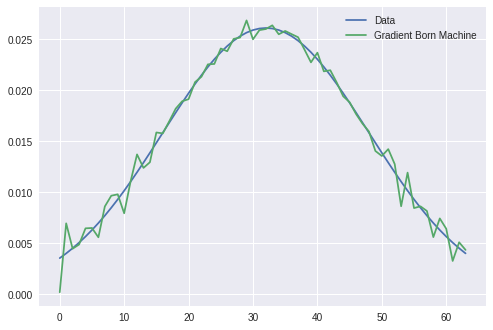

In [29]:
depth = 6
np.random.seed(2)

bm = load_gaussian(6, depth)
theta_list = np.random.random(bm.circuit.num_param)*2*np.pi
loss, theta_list = train(bm, theta_list, 'L-BFGS-B', max_iter=20)
pl = bm.pdf(theta_list)

# display
plt.plot(bm.p_data)
plt.plot(pl)
plt.legend(['Data', 'Gradient Born Machine'])
plt.show()

In [0]:
def load_barstripe(geometry, depth):
    '''3 x 3 bar and stripes.'''
    num_bit = np.prod(geometry)

    # standard circuit
    pairs = get_nn_pairs(geometry)
    circuit = get_diff_circuit(num_bit, depth, pairs)

    # bar and stripe
    p_bs = barstripe_pdf(geometry)

    # mmd loss
    mmd = RBFMMD2(sigma_list=[2.], basis=binary_basis((num_bit,)))

    # Born Machine
    bm = QCBM(circuit, mmd, p_bs)
    return bm

# Training with Noisy Data

Sample size $N=20000$ controls the noises.
We compare training using Adam and SPSA

  Cloning https://github.com/BRML/climin.git to /tmp/pip-req-build-f7nixw9a
  Running setup.py bdist_wheel for climin ... - \ done
  Stored in directory: /tmp/pip-ephem-wheel-cache-74zsd5f4/wheels/de/ad/32/31dd673fcf68b22210ee154d68e90c2f343aac5c48cdb677f9
Successfully built climin
step = 1, loss = 0.01882085680084719
step = 11, loss = 0.005300433636543207
step = 21, loss = 0.0034814224965214174
step = 31, loss = 0.0023963261111020497
step = 41, loss = 0.001087935479401162
step = 51, loss = 0.0009053162251359953
step = 61, loss = 0.001948810443234281
step = 71, loss = 0.0019092107733327751
step = 81, loss = 0.0016138082780207666
step = 91, loss = 0.0009623595977197391


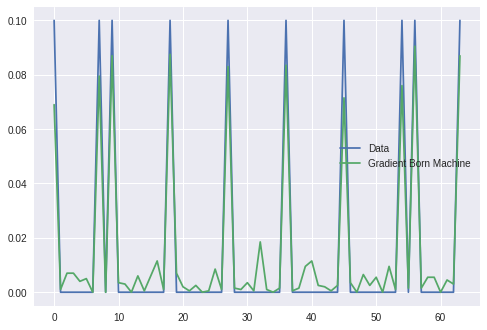

In [69]:
np.random.seed(2)
depth = 4
geometry = (2, 3)

bm = load_barstripe(geometry, depth)
bm.batch_size = 2000
theta_list = np.random.random(bm.circuit.num_param)*2*np.pi
loss, theta_list = train(bm, theta_list, 'Adam', max_iter=100, popsize=10)
pl = bm.pdf(theta_list)

# display
plt.plot(bm.p_data)
plt.plot(pl)
plt.legend(['Data', 'Gradient Born Machine'])
plt.show()

In [16]:
# generate samples
pl = bm.pdf(theta_list)
indices = np.random.choice(np.arange(len(pl)), np.prod(size), p=pl)
samples = binary_basis(geometry)[indices]

# show
size = (7,5)
plot_bs(samples, size)

NameError: ignored

In [0]:
theta_list = np.random.random(bm.circuit.num_param)*2*np.pi
loss, theta_list = train(bm, theta_list, 'SPSA', max_iter=100*bm.circuit.num_param, popsize=10)
pl = bm.pdf(theta_list)

# display
plt.plot(bm.p_data)
plt.plot(pl)
plt.legend(['Data', 'Gradient Born Machine (SPSA)'])
plt.show()

step = 1, loss = 0.014691208563616486
step = 157, loss = 0.014988349456891224
step = 313, loss = 0.014243381672254514


KeyboardInterrupt: ignored

# SPSA not Working?

Lets optimize a problem with 24 parameters

In [0]:
test_func = lambda x: np.cos(x).sum()
max_iter = 2000

step = [0]
def callback(x, *args, **kwargs):
    step[0] += 1
    if step[0]%(max_iter//50) == 1:
        print('step = %d, loss = %s'%(step[0], test_func(x)))
        
res = spsa(test_func, x0=np.random.random(24),
               maxiter=max_iter, callback=callback,
               )

step = 1, loss = 20.796581751465737
step = 41, loss = 17.67989562802431
step = 81, loss = 14.08103567206227
step = 121, loss = 8.745535205647682
step = 161, loss = 4.02103044679887
step = 201, loss = -0.07336469454172878
step = 241, loss = -2.797866790716694
step = 281, loss = -5.78570627582404
step = 321, loss = -8.718937120989885
step = 361, loss = -11.091224065672787
step = 401, loss = -13.055019525299844
step = 441, loss = -14.502209466639925
step = 481, loss = -16.099918437533287
step = 521, loss = -17.25192374217347
step = 561, loss = -18.078309988841006
step = 601, loss = -18.986836301802008
step = 641, loss = -19.573928884899914
step = 681, loss = -20.243853615671508
step = 721, loss = -21.268868044065307
step = 761, loss = -21.74049667232036
step = 801, loss = -22.37825658815569
step = 841, loss = -22.60812656731494
step = 881, loss = -22.882512300222977
step = 921, loss = -23.094404364598198
step = 961, loss = -23.30299976104161
step = 1001, loss = -23.454831268909643
step = 

SPSA is ok, but not for noisy quantum circuits.

# Inference using Amplitude Amplification

# Gradient Vanishing?

* Using random circuit
* the derivative with respect to the parameters $\theta$ is Lipschitz continuous with some parameter $\eta$ that depends on the operator $H$.

$$\langle \partial_k E\rangle =\int dU p(U)\partial _k\langle0|U(\theta)^\dagger HU(\theta)|0\rangle$$

Mcclean, J. R., Boixo, S., Smelyanskiy, V. N., Babbush, R., & Neven, H. (2018). Barren plateaus in quantum neural network training landscapes. arXiv:1803.11173, 1–7. Retrieved from https://arxiv.org/pdf/1803.11173.pdf

In [22]:
depth = 6
np.random.seed(2)

num_bit_list = np.arange(2, 14, 2)
grad_absmean_list = []
for num_bit in num_bit_list:
    print('number of bit = %d'%num_bit)
    bm = load_gaussian(num_bit, depth)
    grad = bm.gradient(np.random.random(bm.circuit.num_param)*2*np.pi)
    grad_absmean_list.append(np.abs(grad).mean())

number of bit = 2
number of bit = 4
number of bit = 6
number of bit = 8
number of bit = 10
number of bit = 12


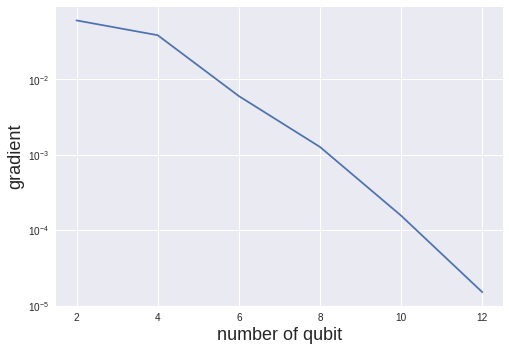

In [29]:
plt.plot(num_bit_list, grad_absmean_list)
plt.yscale('log')
plt.ylabel("gradient", fontsize=18)
plt.xlabel("number of qubit", fontsize=18)
plt.show()

# Inference and Learning Wave Functions
to be added...

#### Ref
Low, Guang Hao, Theodore J. Yoder, and Isaac L. Chuang. "Quantum inference on Bayesian networks." Physical Review A 89.6 (2014): 062315.